In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [2]:
z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init = 2000.
cosmo = Class()
cosmo.set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_h/Mpc' : 1.,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.12,
           'Omega_dcdmdr':0.12,
           'Gamma_dcdm':10
#           'N_ur':0.0,
#           'YHe':0.25,
#           'Omega_b':0.05,
#           'Omega_cdm':0.95
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
cosmo.compute()

In [3]:
bg = cosmo.get_background()
print bg.viewkeys()

dict_keys(['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_dr', '(.)rho_cdm', '(.)rho_dcdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z'])


[  2.51989993e+05   2.51989993e+05   2.51979075e+05 ...,   1.00000113e+00
   1.00000050e+00   1.00000012e+00]


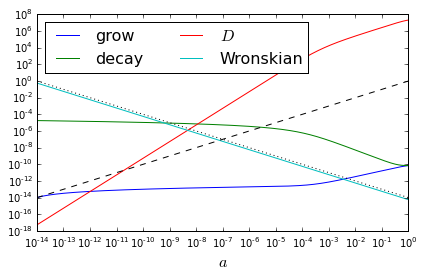

In [4]:
from scipy import interpolate
a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
grow = bg['grow']
grow_prime = bg['grow_prime']
#W= bg['Wronskian']
#decay= bg['decay']
decay= bg['bwdec']
decay_prime = bg['bwdec_prime']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

W = grow*decay_prime-decay*grow_prime

grow_interp = interpolate.interp1d(a,grow)
decay_interp = interpolate.interp1d(a,decay)


N=abs(grow[-1]/decay[-1])
plt.loglog(a,grow,a,N*abs(decay),a,D,a,abs(W))
plt.legend([r'grow',r'decay',r'$D$',r'Wronskian'],fontsize=16,ncol=2,loc='upper left')

plt.loglog(a,a,'k--')
plt.loglog(a,1e-14*a**-1,'k:')
#plt.ylim([1e-18,1e14])
#plt.ylim([1e-74,1e23])
plt.xlabel(r'$a$',fontsize=16)
plt.tight_layout()
plt.savefig('sigmachi.pdf')

print decay

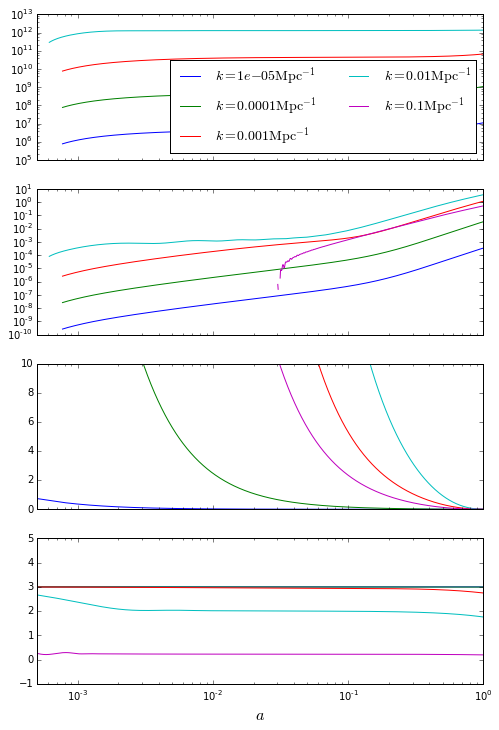

In [6]:
pt = cosmo.get_perturbations()
pts = pt['scalar']
f, [ax1, ax2, ax3, ax4] = plt.subplots(4,1,sharex=True,figsize=(8,12))

for idx, k in enumerate(k_out):
    pt = pts[idx]
    S1 = grow_interp(pt['a'])
    S2 = decay_interp(pt['a'])
    HTNb = pt['H_T_nm']+k*pt['L']
    ax1.loglog(pt['a'],pt['CHT_grow'])
    ax2.loglog(pt['a'],-pt['CHT_decay'])
    ax3.semilogx(pt['a'],np.abs((pt['CHT_grow']-pt['CHT_grow'][-1])*S1+(pt['CHT_decay']-pt['CHT_decay'][-1]+0.0)*S2+.0*HTNb))
    ax4.semilogx(pt['a'],np.abs(HTNb))
    
ax1.legend(['$k = '+str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out], fontsize=14,loc='lower right',ncol=2)
ax2.set_xlim([1./(z_init+1.),1e0])
ax3.set_ylim([0,10])
ax4.set_ylim([-1,5])

ax4.set_xlabel(r'$a$',fontsize=16)

In [6]:
amin = 1e-4
# Compute kappa+
kp = -(chi2-f*a*H*sigma2)/(chi1-a*H*f*sigma1)
Np = D/(sigma2+kp*sigma1)

plt.loglog(a,abs(kp),a,Np)
plt.legend([r'$-\kappa_+$',r'$N_+$'],loc='upper left',fontsize=16)
plt.xlim([amin,1.])
plt.ylim([1e-4,1e9])
plt.figure()
plt.loglog(a,D,':',lw=2)
idx = np.argmax(a>1e-2)
plt.plot(a,Np[idx]*(sigma2+kp[idx]*sigma1),lw=2)
plt.legend([r'$D_\mathrm{CLASS}$',
            r'$N_+[-1](D-\chi+\kappa_+[-1] D_\sigma)$'],loc='lower right',fontsize=16)
plt.xlim([amin,1.])
plt.ylim([1e-7, 1e22])

plt.figure()
s1 = sigma1/(chi2*sigma1-chi1*sigma2)
s2 = sigma2/(chi1*sigma2-chi2*sigma1)
plt.loglog(a,s1,'-')
plt.loglog(a,-s2,'--')

plt.xlabel(r'$a$',fontsize=16)
leg = [r'$\frac{D_\sigma}{\dot{D}_\chi D_\sigma-\dot{D}_\sigma D_\chi}$',
       r'$\frac{D_\chi}{\dot{D}_\sigma D_\chi-\dot{D}_\chi D_\sigma}$']
plt.legend(leg,loc='upper left',fontsize=16)

plt.xlim([amin,1.])
plt.tight_layout()
plt.savefig('CHT_sources.pdf')


NameError: name 'chi2' is not defined

In [36]:
print sigma1interp(0.1)

NameError: name 'sigma1interp' is not defined

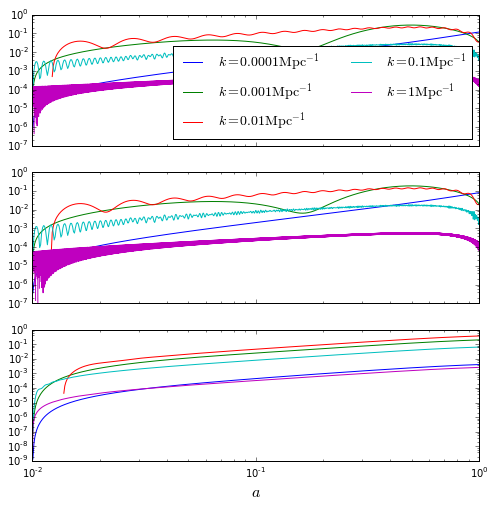

In [28]:
pt = cosmo.get_perturbations()
pts = pt['scalar']
f, [ax1, ax2, ax3] = plt.subplots(3,1,sharex=True,figsize=(8,8))

for idx, k in enumerate(k_out):
    pt = pts[idx]
    S1 = sigma1interp(pt['a'])
    S2 = sigma2interp(pt['a'])
    ax1.loglog(pt['a'],pt['CHT_chi'])
    ax2.loglog(pt['a'],-pt['CHT_sigma'])
    ax3.loglog(pt['a'],pt['CHT_chi']*S2+pt['CHT_sigma']*S1)

ax1.legend(['$k = '+str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out], fontsize=14,loc='lower right',ncol=2)
ax2.set_xlim([1e-2,1e0])
ax3.set_xlabel(r'$a$',fontsize=16)

/Users/thomas/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide


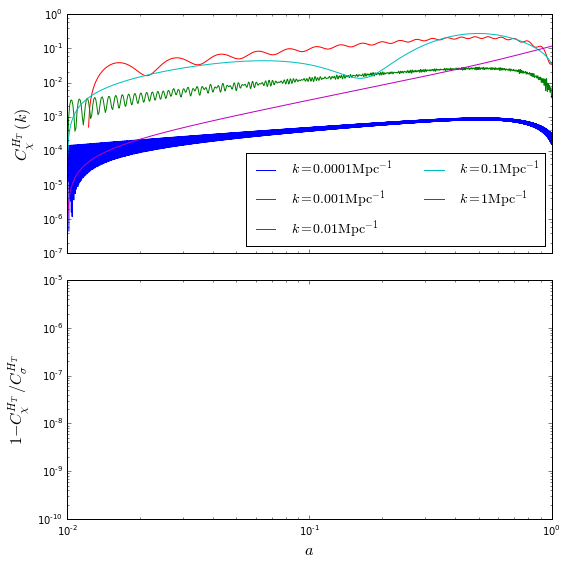

In [20]:
pt = cosmo.get_perturbations()
pts = pt['scalar']
f, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(8,8))
for idx, k in reversed(list(enumerate(k_out))):
    pt = pts[idx]
    if idx==0:
        lw = 1
    else:
        lw=2
    ax1.loglog(pt['a'],pt['CHT_chi'])
    scale = -pt['CHT_chi'][-1]/pt['CHT_sigma'][-1]
    ax2.loglog(pt['a'],np.abs(1-pt['CHT_chi']/(-pt['CHT_sigma'])/scale),lw=lw)

ax1.legend(['$k = '+str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out], fontsize=14,loc='lower right',ncol=2)
ax2.set_xlim([1e-2,1e0])
ax2.set_ylim([1e-10,1e-5])
ax2.set_xlabel(r'$a$',fontsize=16)
ax1.set_ylabel(r'$C^{H_T}_\chi(k)$',fontsize=16)
ax2.set_ylabel(r'$1-C^{H_T}_\chi/C^{H_T}_\sigma$',fontsize=16)
f.tight_layout()
f.savefig('CHT_sigmachi.pdf')

In [30]:
print scale

9593446.61185
